In [99]:
import pandas as pd
import numpy as np
import os
import IPython.core.display as di
import sqlalchemy as sql
import seaborn as sns
import matplotlib.pyplot as plt
import nbconvert.utils.pandoc
pd.options.display.max_colwidth = 40
pd.options.display.float_format = '{:,.0f}'.format
from sqlalchemy import text
from IPython.display import display, HTML
%matplotlib inline
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [100]:
StartDate = '1/1/2016'
EndDate = '2/1/2017'
Physician = '16379'

os.chdir('X:\DBM\!Data')
CC = pd.read_excel("CC Mapping Master.xlsx")
os.chdir('X:\DBM\!Data\PhysicianTracker')

qy = open('PrimaryDX.sql').read()
qy = qy.replace('start_var',StartDate)
qy = qy.replace('end_var',EndDate)

op = open('phys_tracker_CompApp.sql').read()
op = op.replace('start_var',StartDate)
op = op.replace('end_var',EndDate)

ip = open('DRG.sql').read()
ip = ip.replace('start_var',StartDate)
ip = ip.replace('end_var',EndDate)

log = open('OR_LOG.sql').read()
log = log.replace('start_var',StartDate)
log = log.replace('end_var',EndDate)

month_names = []
month_ints = []

#reorder this for trailing twelve months
CY_order = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','All']
CY_int = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}


In [101]:
def RunQuery(q,merge=True):

    #query = open(q).read()

    DB = {
        'drivername': 'mssql+pyodbc',
        'servername': 'EPIC-P-CLARITY',
        'port': '5432',
        'database': 'CLARITY',
        'driver': 'SQL Server Native Client 11.0',
        'trusted_connection': 'yes',  
        'legacy_schema_aliasing': False
    }
    # Create the connection
    engine = sql.create_engine(DB['drivername'] + '://' + DB['servername'] +
                           '/' + DB['database'] + '?' + 'driver=' + 
                           DB['driver'] + ';' + 'trusted_connection=' + 
                           DB['trusted_connection'], 
                           legacy_schema_aliasing=DB['legacy_schema_aliasing'])
    # Required for querying tables
    con = engine.connect()
    metadata = sql.MetaData(con)
    df = pd.read_sql(q,con = con)
    df['Count']=1
    if(merge):
        df = df.merge(CC[['DEPARTMENT_NAME','Lawson Name']],left_on='department_name',right_on='DEPARTMENT_NAME',how='left')
    return df

In [102]:
def build_dash(df,id,_index,count = 1000,prov_type='attending_prov_id',_count='hsp_account_id',_func='count'):
    df = df[df[prov_type]==str(id)]
    df = pd.pivot_table(df
             ,columns='month_abr'
             ,index=[_index]
             ,values=[_count]
             ,aggfunc={_count:_func}
             ,margins=True
             ,fill_value=0
         )
    df = df[_count]
    cols = df.columns.tolist()
    order = []
    int_order = []
    for i in CY_order:
        if i in cols:
            order.append(i)
            if i != 'All': int_order.append(CY_int[i])
    #order.append('All')
    global month_names
    global month_ints
    month_names = order
    #month_names = month_names.remove(month_names[len(month_names)-1])
    month_ints = int_order
    df.sort_values(by='All',ascending=0)
    df = df.sort_values(by='All',ascending=0)
    df = df[order]
    df = df.reset_index()
    df = df[df[_index] != 'All']
    Total = pd.DataFrame([ColSum(df,'Total')],columns=df.columns)
    df = df.head(count)
    Other = pd.DataFrame([ColSum(df,'Other')],columns=df.columns)
    Other = Total.iloc[:,1:].subtract(Other.iloc[:,1:])
    Other[_index] = 'Other'
    Other = ColMove(Other,_index)
    if(Other['All'][0]==0):
        df = df.append(Total)
    else:
        df = df.append(Other).append(Total)   
    df.columns.name = ''
    return df

In [103]:
def ColMove(_df,_name,move_to=0):
    name = _df[_name]
    _df.drop(labels=[_name],axis=1,inplace=True)
    _df.insert(move_to,_name,name)
    return _df

In [104]:
def ColSum(_df,title):
    row_total = []
    
    for i in range(0,len(_df.columns)):
        if i == 0:
            row_total.append(title)
        else:
            row_total.append(_df.iloc[:,i].sum())
    
    return row_total

In [105]:
def line_plot(df,axis,detail=False):
    if detail==False: df = df.tail(1)
    df = df.iloc[:,0:len(df.columns)-1]  
    plt.figure(figsize=(6,3))
    p = sns.pointplot(data=df)
    sns.set_style("white")
    sns.despine()
    p.set_ylabel(axis)
    return p

In [106]:
dx = RunQuery(qy)
op = RunQuery(op)
ip = RunQuery(ip)
log = RunQuery(log,False)

@media print {
    h3 {page-break-before: always;}
}

<h2>Physician Summary Sample Data</h2>
<i>8/1/2016 - 1/31/2017</i>

<h3>Inpatient Discharges by DRG</h3>
<p style="page-break-after:always;"></p>
<div style="page-break-after: always;"></div>
<i>Attending physician, by discharge date, coded encounters only</i>


In [107]:
test = build_dash(ip,'16379','drg',10)

display(HTML(test.to_html(index=False)))

drg,Aug,Sep,Oct,Nov,Dec,Jan,All
"13 TRACHEOSTOMY FOR FACE,MOUTH & NEC...",1,0,0,1,0,1,3
"11 TRACHEOSTOMY FOR FACE,MOUTH & NEC...",0,1,1,0,0,0,2
"134 OTHER EAR, NOSE, MOUTH & THROAT ...",1,0,0,0,0,0,1
"154 OTHER EAR, NOSE, MOUTH & THROAT ...",0,0,1,0,0,0,1
"156 OTHER EAR, NOSE, MOUTH & THROAT ...",1,0,0,0,0,0,1
163 MAJOR CHEST PROCEDURES W MCC,0,0,1,0,0,0,1
166 OTHER RESP SYSTEM O.R. PROCEDURE...,0,1,0,0,0,0,1
"326 STOMACH, ESOPHAGEAL & DUODENAL P...",0,0,0,0,0,1,1
"392 ESOPHAGITIS, GASTROENT & MISC DI...",0,0,0,1,0,0,1
603 CELLULITIS W/O MCC,0,0,0,0,1,0,1


<p style="page-break-after:always;"></p>

<h3>Inpatient Cases by Primary Diagnosis </h3>
<i>Attending physician, by discharge date, coded encounters only</i>

dx_name,Aug,Sep,Oct,Nov,Dec,Jan,All
Other specified diseases of upper re...,0,1,2,0,0,0,3
Cellulitis of left external ear,1,0,0,0,0,0,1
Cutaneous abscess of neck,0,0,0,0,1,0,1
"Dysphagia, pharyngoesophageal phase",0,0,0,0,0,1,1
"Dysphagia, unspecified",0,0,0,1,0,0,1
Malignant neoplasm of glottis,0,1,0,0,0,0,1
Malignant neoplasm of overlapping si...,1,0,0,0,0,0,1
Malignant neoplasm of supraglottis,0,0,0,1,0,0,1
Obstructive sleep apnea (adult) (ped...,1,0,0,0,0,0,1
"Other complications of procedures, n...",0,1,0,0,0,0,1


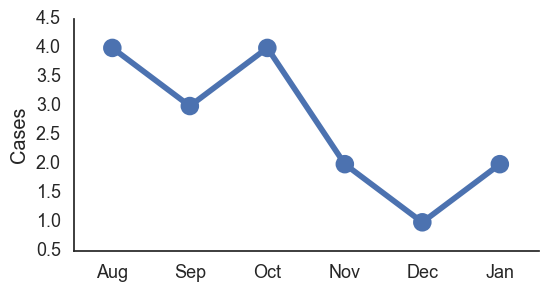

In [108]:
test = build_dash(dx.query('baseclass == 1'),'16379','dx_name',10)
display(HTML(test.to_html(index=False)))
line_plot(test,'Cases');

<h3>Outpatient Cases by Primary Diagnosis</h3>
<i>Attending physician, by discharge date, coded encounters only</i>

dx_name,Aug,Sep,Oct,Nov,Dec,Jan,All
"Sensorineural hearing loss, bilateral",12,12,5,8,9,6,52
Dysphonia,9,4,4,3,8,19,47
"Dysphagia, unspecified",3,7,5,7,8,9,39
Other diseases of larynx,4,6,7,9,8,4,38
Other diseases of vocal cords,1,3,8,5,8,7,32
"Paralysis of vocal cords and larynx,...",4,8,5,6,4,2,29
Stenosis of larynx,2,2,9,2,6,6,27
Encounter for other preprocedural ex...,2,8,9,5,0,1,25
Other specified diseases of upper re...,4,4,7,1,3,4,23
Obstructive sleep apnea (adult) (ped...,3,5,5,2,1,2,18


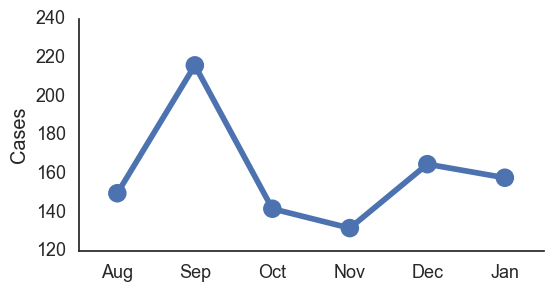

In [109]:
test = build_dash(dx.query('baseclass == 2'),'16379','dx_name',10)
display(HTML(test.to_html(index=False)))
line_plot(test,'Cases');

<h3>Clinic Visits by Department</h3>
<i>Attending physician, by encounter date</i>

Lawson Name,Aug,Sep,Oct,Nov,Dec,Jan,All
ENT Clinic,116,173,107,96,128,121,741
Physical Therapy,37,54,31,27,39,31,219
PAT PreAnesthesia Testing,7,13,18,11,11,15,75
CT/MR,3,4,4,1,7,5,24
Diagnostic Imaging,1,0,4,1,2,4,12
MRI,0,1,0,0,1,2,4
Medicine Specialty Clinic,0,0,0,0,0,4,4
Ambulatory Care Admin,0,0,3,1,0,0,4
Chemistry,0,2,2,0,0,0,4
Family Practice Clinic,0,0,1,0,1,0,2


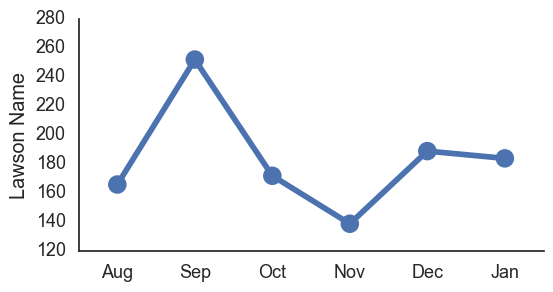

In [110]:
test = build_dash(op,'16379','Lawson Name',10)
display(HTML(test.to_html(index=False)))
line_plot(test,'Lawson Name');

<h3>Clinic Visits by Financial Class</h3>
<i>Attending Physician, by encounter date</i>

fin_class,Aug,Sep,Oct,Nov,Dec,Jan,All
Medicaid,54,90,50,44,63,72,373
Commercial,49,78,55,47,59,42,330
Medicare,43,65,52,36,53,53,302
Free Care,17,14,13,10,13,12,79
Self-pay,3,5,2,2,1,5,18
Total,166,252,172,139,189,184,"1,102"


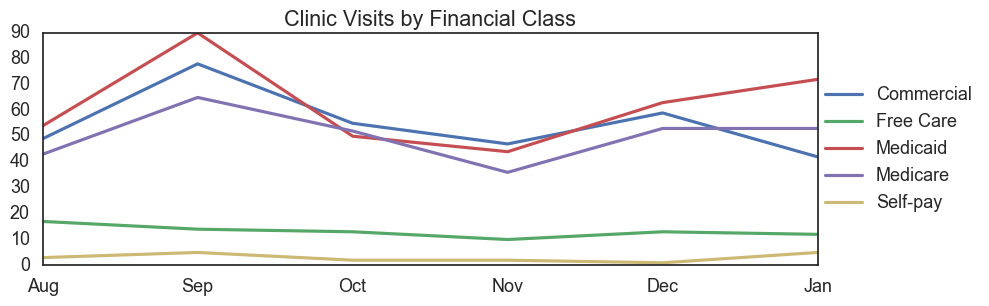

In [111]:
test = build_dash(op,'16379','fin_class',10)
display(HTML(test.to_html(index=False)))
#plot
t= op.groupby(['fin_class','APPT_MONTH']).count()['hsp_account_id'].unstack().transpose()
t= t.reindex(month_ints).reset_index()
t.columns.name = ''
t= t.drop(t.columns[0],axis=1)
plot = t.plot(figsize=(10,3),title='Clinic Visits by Financial Class')
#plot.set_xticks(month_ints)
plot.set_xticklabels(labels=month_names)
plt.legend(bbox_to_anchor=(1.22,.5), loc='right', ncol=1);

<h3>Inpatient Charges by Financial Class</h3>
<i>Attending physician, by discharge date, coded encounters only</i>

In [112]:
test = build_dash(dx.query('baseclass == 1'),'16379','fin_class',10,_count='tot_chgs',_func='sum')
display(HTML(test.to_html(index=False)))

fin_class,Aug,Sep,Oct,Nov,Dec,Jan,All
Commercial,"67,016","34,286","89,908","18,297",0,0,"209,506"
Medicare,0,"43,056","80,105",0,0,"70,174","193,334"
Medicaid,"40,406",0,"36,767",0,"3,904","14,149","95,226"
Total,"107,422","77,342","206,780","18,297","3,904","84,323","498,066"


<h3>Outpatient Charges by Financial Class</h3>
<i>Attending Physician, by discharge date, coded encounters only</i>

In [113]:
test = build_dash(dx.query('baseclass == 2 | baseclass == 3'),'16379','fin_class',10,_count='tot_chgs',_func='sum')
display(HTML(test.to_html(index=False)))

fin_class,Aug,Sep,Oct,Nov,Dec,Jan,All
Commercial,"25,552","50,305","71,736","65,658","75,733","87,224","376,209"
Medicare,"27,386","75,820","64,790","52,482","60,955","79,479","360,911"
Medicaid,"23,699","47,724","44,556","39,353","47,990","54,039","257,360"
Free Care,"9,545","19,161","12,794","4,334","4,663","10,466","60,962"
Self-pay,"1,201","1,974","1,299",748,"8,059","1,838","15,119"
Total,"87,383","194,984","195,174","162,576","197,399","233,046","1,070,562"


<h3>Total Charges by Financial Class</h3>
<i>Attending Physician, by discharge date, coded encounters only</i>

fin_class,Aug,Sep,Oct,Nov,Dec,Jan,All
Commercial,"92,568","84,591","161,644","83,956","75,733","87,224","585,715"
Medicare,"27,386","118,876","144,895","52,482","60,955","149,653","554,246"
Medicaid,"64,104","47,724","81,323","39,353","51,893","68,189","352,586"
Free Care,"9,545","19,161","12,794","4,334","4,663","10,466","60,962"
Self-pay,"1,201","1,974","1,299",748,"8,059","1,838","15,119"
Total,"194,804","272,325","401,953","180,873","201,303","317,370","1,568,629"


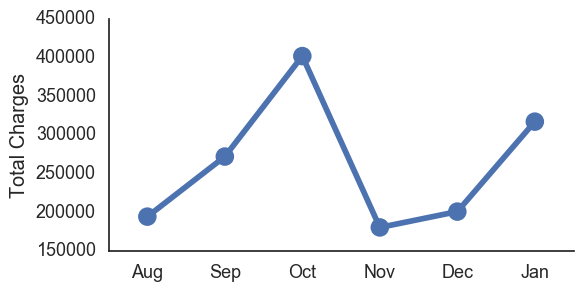

In [114]:
test = build_dash(dx,'16379','fin_class',10,_count='tot_chgs',_func='sum')
display(HTML(test.to_html(index=False)))

line_plot(test,'Total Charges');

<h3>OR Logs by Primary Procedure</h3>
<i>Lead surgeon, by surgery date</i>

prim_procedure,Jul,Aug,Sep,Oct,Nov,Dec,Jan,All
LARYNGOSCOPY MICRO WITH LASER,0,0,0,2,3,5,11,21
TRACHEOTOMY,0,0,2,1,1,0,3,7
PANENDOSCOPY,0,2,2,2,0,0,0,6
DIRECT LARYGOSCOPY RIGID BRONCH TRAC...,0,1,3,1,0,0,0,5
ESOPHAGOSCOPY DILATION WITH BOUGIE,0,0,1,1,2,1,0,5
ENDOSCOPIC AIRWAY SUSPENSION MICROLA...,0,0,4,0,0,0,0,4
TRACHEOTOMY/PANENDOSCOPY,0,0,0,1,2,0,0,3
SUSPENSION MICRO-LARYNGOSCOPY (SML),0,0,0,1,1,1,0,3
ENDOSCOPIC AIRWAY SUSPENSION MICROLA...,0,0,0,0,2,0,0,2
LARYNGOSCOPY DIRECT,0,1,1,0,0,0,0,2


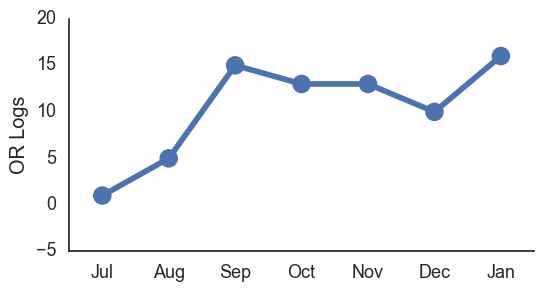

In [115]:
test = build_dash(log,'16379','prim_procedure',10,prov_type='srg_prov_id',_count='log_id')
display(HTML(test.to_html(index=False)))
line_plot(test,'OR Logs');